In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cpu')#"cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import os

os.chdir("D:/L3S/Multi-Fair/Multi-versions/")

In [3]:
from DataPreprocessing.load_kdd import load_kdd
X, yo, sa_index, p_Group, x_control,Ft = load_kdd()
protected=[Ft[v] for v in sa_index]

In [23]:
from sklearn.model_selection import train_test_split
import numpy as np
y=[0 if v==-1 else 1 for v in yo]#y=[[0] if v==-1 else [1] for v in yo]#
ids=np.arange(len(X))
X_main, X_test, y_main, y_test,in_m,in_ts = train_test_split(X, y,ids, test_size=0.25, stratify=y,random_state=48)


In [24]:
X_train, X_val, y_train, y_val,in_tr,in_val = train_test_split(X_main, y_main,in_m, test_size=0.3, stratify=y_main,random_state=48)
x_control_train={}
for v in x_control:
    x_control_train[v]=x_control[v][in_tr]
    
x_control_val={}
for v in x_control:
    x_control_val[v]=torch.tensor(x_control[v][in_val]).to(device) 
x_control_test={}
for v in x_control:
    x_control_test[v]=x_control[v][in_ts]

#  
# The network is a fully connected NN with five layers
## The output layer has two nodes which intends to output one-hot encoded Binary class
### Output activation is softmax which is already present in the Cross-entropy loss function to be called later

In [25]:

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(X.shape[-1], 1024)  
        self.bn1= nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128,32)
        self.fc5 = nn.Linear(32,2)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# 
# In this block defined the two loss functions to be used
## The first function measures the loss wrt each class: 
###  This loss function is defined to handle the class imbalance problem, so that the network can optimized with the class loss gradient of the most underperforming class. Lets call it $L_{class}$
##  
## The second function measures the Fairness loss:
### This function outputs two different values: 
###                                    1) the first one is the differentiable cross-entropy (CE) version of the ${MMM}_{loss}$  (Multi-Fair). Its Lets call it ${MMM}_{ce}$
###                                    2) the second one is an array of loss containing CE loss wrt each groups within each class (i.e $[{fnr}_j, {fnr}_\bar{j}, {fpr}_j, {fpr}_\bar{j}]~\forall  S_j$). Lets call it $L_g$
####  
### Thus all the losses that will be needed in the follow up experiments are defined here at a single place

In [29]:
def max_class_loss(output, target):
    index_1=torch.squeeze(torch.nonzero(target[:] == 1.))
    index_0=torch.squeeze(torch.nonzero(target[:] == 0.))
    l1=F.cross_entropy(torch.index_select(output, 0, index=index_1),torch.index_select(target, 0, index=index_1))
    
    l0=F.cross_entropy(torch.index_select(output, 0, index=index_0),torch.index_select(target, 0, index=index_0))

    #print(l0,l1)
    return l1,l0

def mmm_loss(output,target,x_control):
    L=torch.zeros(len(x_control))
    L_g=torch.zeros(len(x_control),4)
    i=0
    for v in x_control:
        prot_att=x_control[v]
        index_prot=torch.squeeze(torch.nonzero(prot_att[:] == 1.))
        target_prot=torch.index_select(target, 0, index=index_prot)
        index_prot_pos=torch.squeeze(torch.nonzero(target_prot[:] == 1. ))
        index_prot_neg=torch.squeeze(torch.nonzero(target_prot[:] == 0. ))
        
        index_non_prot=torch.squeeze(torch.nonzero(prot_att[:] == 0.))
        target_non_prot=torch.index_select(target, 0, index=index_non_prot)
        index_non_prot_pos=torch.squeeze(torch.nonzero(target_non_prot[:] == 1. ))
        index_non_prot_neg=torch.squeeze(torch.nonzero(target_non_prot[:] == 0. ))
        
        l_prot_pos=F.cross_entropy(torch.index_select(output, 0, index=index_prot_pos),torch.index_select(target, 0, index=index_prot_pos))    
        l_non_prot_pos=F.cross_entropy(torch.index_select(output, 0, index=index_non_prot_pos),torch.index_select(target, 0, index=index_non_prot_pos))    
        l_non_prot_neg=F.cross_entropy(torch.index_select(output, 0, index=index_non_prot_neg),torch.index_select(target, 0, index=index_non_prot_neg))
        l_prot_neg=F.cross_entropy(torch.index_select(output, 0, index=index_prot_neg),torch.index_select(target, 0, index=index_prot_neg))    
        
        dl_pos=torch.max((l_prot_pos-l_non_prot_pos),-(l_prot_pos-l_non_prot_pos))
        dl_neg=torch.max((l_prot_neg-l_non_prot_neg),-(l_prot_neg-l_non_prot_neg))
        L[i]=torch.max(dl_pos,dl_neg)
        L_g[i][0]=l_prot_pos #torch.tensor([l_prot_pos,l_prot_neg,l_non_prot_pos,l_non_prot_neg])
        L_g[i][1]=l_prot_neg
        L_g[i][2]=l_non_prot_pos
        L_g[i][3]=l_non_prot_neg
        i+=1

    #print(L_g,'\n')
    return torch.max(L),L_g

In [19]:
import numpy as np
from DataPreprocessing.my_utils import get_score,get_fairness,vis

#  
## In this block we run our first experiment. 
### Here to tune our network 
### we use gradients of ${MMM}_{ce}~if ~ {MMM}_{ce}>\theta$ (a threshold chosen by cross-validation)   
### else   we use gradients of $max(L_{class})$
####      


#### The reason to use threshold because if we use $max(max(L_class), {MMM}_{ce})$ then the algorithm always choses $L_{class}$ as >> ${MMM}_{ce}$ everytime.  Another possibility here is to use the sum.

#### The best model is selected based on fairness and performance outcomes on a validation set 

In [30]:
path='D:/L3S/MOO_NN/saved_models/FNN/best_model_bce.pt'

net=Net()
net.to(device)
optimizer = optim.AdamW(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
epoch_loss=[]
epoch_loss_groups=[]
epoch_loss_class=[]
val_epoch_wgacc=[]
val_epoch_wpdm=[]
results_epoch=[]
for epoch in range(200):  # loop over the dataset multiple times

    running_loss = 0.0
    groups_batch_loss=[]
    class_batch_loss=[]
    batch_loss=[]
    i,batch=0,4096
    while(i<len(X_train)):
        # get the inputs; data is a list of [inputs, labels]
        xc={}
        if (i+batch)<len(X_train):
            inputs, labels = torch.tensor(X_train[i:i+batch]),torch.tensor( y_train[i:i+batch])#.float()
            i=i+batch
            for v in x_control_train:
                xc[v]=torch.tensor(x_control_train[v][i:i+batch]).to(device)
        else:
            inputs, labels = torch.tensor(X_train[i:]),torch.tensor(y_train[i:])#.float()
            i=len(X_train)
            for v in x_control_train:
                xc[v]=torch.tensor(x_control_train[v][i:]).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device).float())
        loss_fairness,loss_all_groups = mmm_loss(outputs,labels.to(device),xc)
        loss_pos,loss_neg=max_class_loss(outputs, labels.to(device))
        loss_per=torch.max(loss_pos,loss_neg)
        if loss_fairness>0.03:
            loss=loss_fairness#torch.max(loss_all_groups)
        else:
            loss=loss_per
        loss.backward()
        optimizer.step()

        # print statistics
        if str(loss_fairness.item())!="nan":
            batch_loss.append([loss_per,loss_fairness])
            groups_batch_loss.append(loss_all_groups)
            class_batch_loss.append([loss_pos,loss_neg])
            running_loss += loss_fairness.item()
        #print(running_loss)
        if i%10000==0:
            print(i,batch_loss[-1],groups_batch_loss[-1])
    epoch_loss.append(sum(np.array(batch_loss))*batch/len(X_train))
    epoch_loss_groups.append(np.array(sum(groups_batch_loss).detach())*batch/len(X_train))
    epoch_loss_class.append(sum(np.array(class_batch_loss))*batch/len(X_train))
    print('\n--------------At Epoch ',epoch,' training Loss is ',epoch_loss[-1],'\n','loss per group is: ',epoch_loss_groups[-1])
    #epoch_loss=np.array(epoch_loss)
    with torch.no_grad():
        pred1=net(torch.tensor(X_val).to(device).float())
        _,val_loss=mmm_loss(pred1,torch.tensor(y_val).to(device),x_control_val)
    print('\n--------------','validation loss per group is: ',epoch_loss_groups[-1])    
    rs1=get_fairness(sa_index,p_Group,[in_val],[np.argmax(pred1,axis=1)],X,yo)  #[0 if v[0]<0.5 else 1 for v in pred1]

    results_epoch.append(list(rs1.values()))
    wg,p,mxd=[],0,0
    for v in rs1:
        wg.append(min(rs1[v][:4]))
        if rs1[v][4]>mxd:
            mxd=rs1[v][4]
            p=v
    val_epoch_wgacc.append(min(wg))
    val_epoch_wpdm.append(mxd)
    print('\n  Validation worst group accuracy: ',val_epoch_wgacc[-1],' worst DM: ', mxd,' Attribute: ',Ft[p])
    #performance=np.array([pf1])
    if val_epoch_wgacc[-1]>=max(val_epoch_wgacc) or val_epoch_wpdm[-1]<=min(val_epoch_wpdm):
        torch.save(net.state_dict(),path)
    if epoch>10:
        if max(val_epoch_wgacc[-5:])<=val_epoch_wgacc[-10] and min(val_epoch_wpdm[-5:])>=val_epoch_wpdm[-10]:
            break


--------------At Epoch  0  training Loss is  [tensor(0.5108, grad_fn=<DivBackward0>)
 tensor(0.0504, grad_fn=<DivBackward0>)] 
 loss per group is:  [[0.39782761 0.39307671 0.38685946 0.39263419]
 [0.40357362 0.39237044 0.38916074 0.39395149]]

-------------- validation loss per group is:  [[0.39782761 0.39307671 0.38685946 0.39263419]
 [0.40357362 0.39237044 0.38916074 0.39395149]]

  Validation worst group accuracy:  0.6957001102535832  worst DM:  0.37486631817455707  Attribute:  sex

--------------At Epoch  1  training Loss is  [tensor(0.5500, grad_fn=<DivBackward0>)
 tensor(0.0634, grad_fn=<DivBackward0>)] 
 loss per group is:  [[0.22355087 0.22052979 0.20906052 0.2191966 ]
 [0.22769735 0.21950485 0.21469272 0.22158114]]

-------------- validation loss per group is:  [[0.22355087 0.22052979 0.20906052 0.2191966 ]
 [0.22769735 0.21950485 0.21469272 0.22158114]]

  Validation worst group accuracy:  0.7276736493936052  worst DM:  0.3497790939391182  Attribute:  sex

--------------At E

In [21]:
y=[[0,1] if v==-1 else [1,0] for v in y]

In [23]:
sum(np.array(y)[:,0])

18568

In [32]:
net=Net()
net.load_state_dict(torch.load(path))

<All keys matched successfully>

#    

In [33]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
#np.argmax(pred,axis=1)
with torch.no_grad():
    pred=net(torch.tensor(X_test).float())
target_name=['negative','positive']
print(confusion_matrix(y_test,np.argmax(pred,axis=1)))
print(classification_report(y_test,np.argmax(pred,axis=1),target_names=target_name))
rs1=get_fairness(sa_index,p_Group,[in_ts],[np.argmax(pred,axis=1)],X,y)
pf1=get_score([np.argmax(pred,axis=1)],[in_ts],X,y)

[[58785 11395]
 [  488  4154]]
              precision    recall  f1-score   support

    negative       0.99      0.84      0.91     70180
    positive       0.27      0.89      0.41      4642

    accuracy                           0.84     74822
   macro avg       0.63      0.87      0.66     74822
weighted avg       0.95      0.84      0.88     74822



### In the above block we see the performance of the model on test data in terms of precision, recall, and f1
#### We notice that the performance is high across both the classes with slightly higher on the minority positive class
## -------------------------------------------------------------------------------------------------------------------
#### In the block below we see the plot of the performance report in fairness and predictive accuracy across all classes and protected attributes (first is Race, second is Sex). 
 

#### The first thing we can notice here is that the prediction are comaparitively fair wrt Race than wrt Sex with DM for Sex being twice as that for Race. 
   
#### Another very important observation is that CDM values are very low for both attributes compared to the high DM values. This indicates unfairness exist in both the classes with discrimination in one class and reverse discrimination in the other class (as par the CDM theory presented in Multi-Fair paper)

['CDM', 'DM', 'CDM', 'DM', 'MMM', 'TPR', 'TNR', 'Acc', 'AUC', 'G.Mean']
[[0.021761618573609698, 0.1265076354247251, 0.0326093184622146, 0.3134526916147141, 0.16528551463496255, 0.8948728996122362, 0.8376318039327444, 0.8411830744968057, 0.8662523517724903, 0.8948690957592423]]


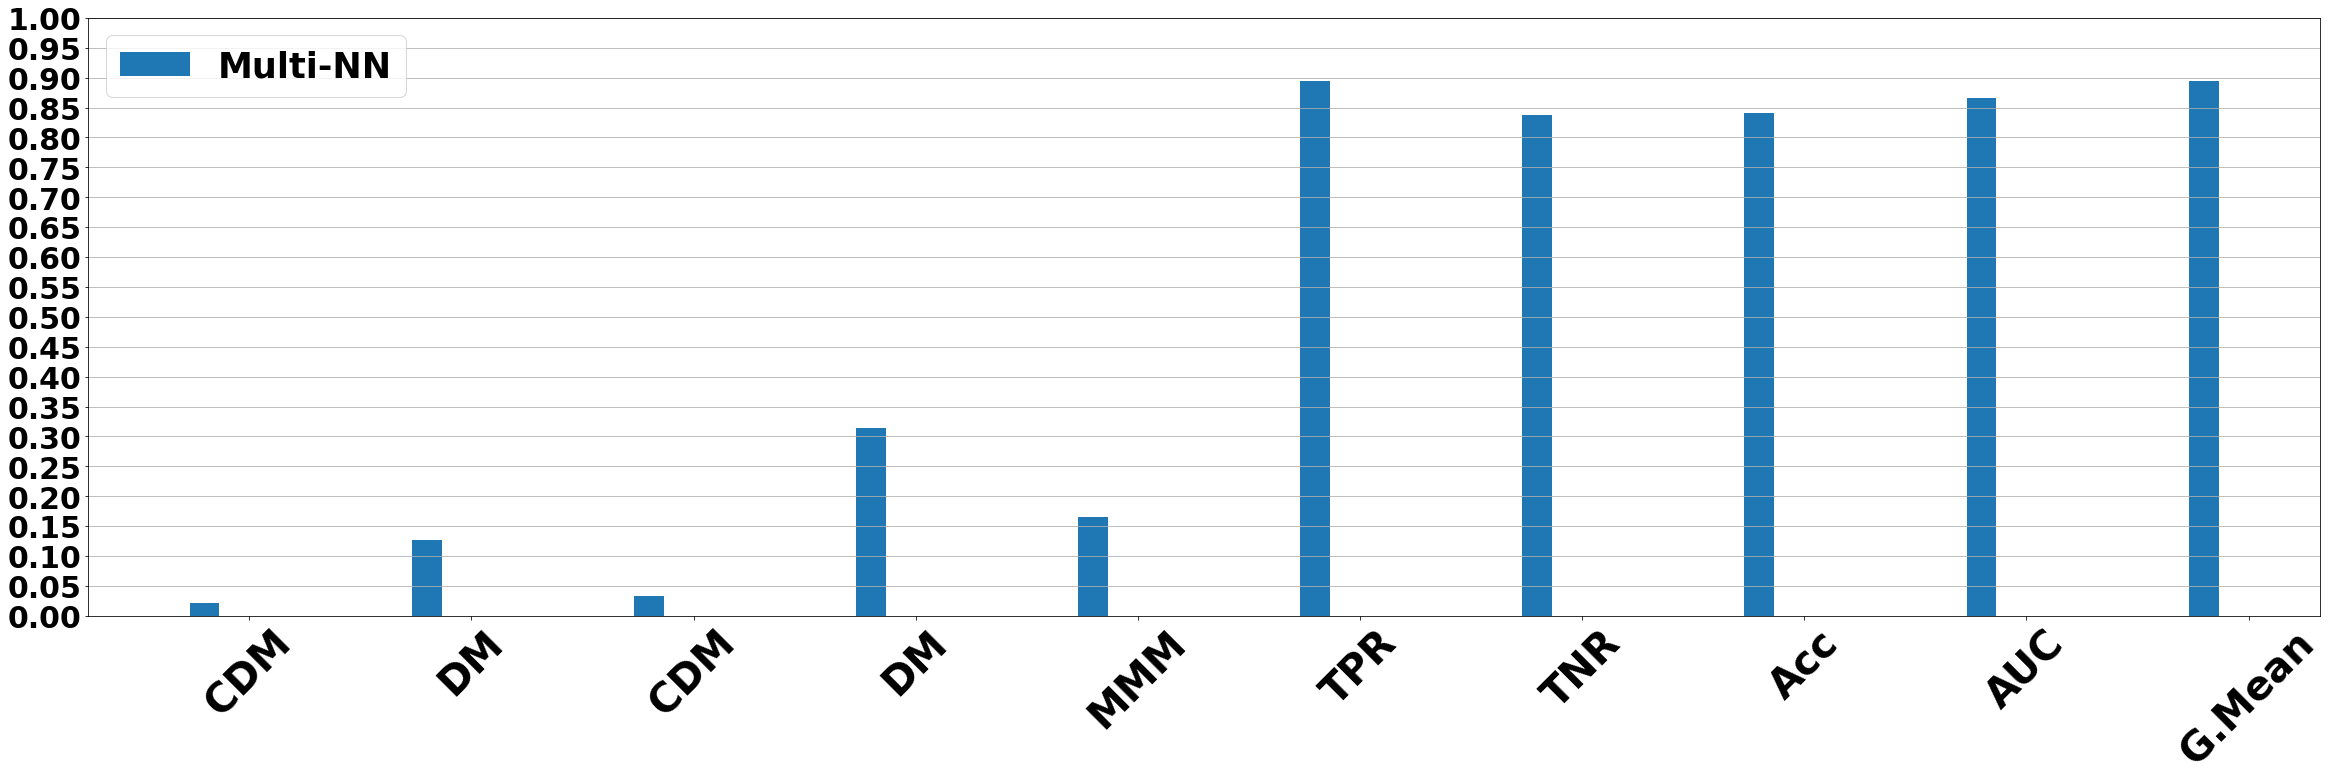

In [34]:
results=np.array([list(rs1.values())])
performance=np.array([pf1])
vis('',results,performance,L=protected,dt='kdd',clfs=['Multi-NN'])

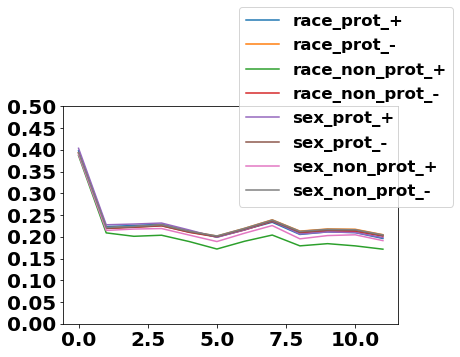

In [44]:
j=0
plt.ylim([0,0.5])
plt.rcParams.update({'font.size': 20})
plt.yticks(np.arange(0, 0.51, step=0.05))
for v in x_control:
    plt.plot(np.array(epoch_loss_groups)[:,j,0],label=v+'_prot_+')
    plt.plot(np.array(epoch_loss_groups)[:,j,1],label=v+'_prot_-')
    plt.plot(np.array(epoch_loss_groups)[:,j,2],label=v+'_non_prot_+')
    plt.plot(np.array(epoch_loss_groups)[:,j,3],label=v+'_non_prot_-')
    j+=1
plt.legend(loc=3, bbox_to_anchor=(0.5, 0.5),fancybox=True,fontsize='small')

### The plot above shows the training loss of each groups. Here we see that the errors for all groups though remains close to each other but a gap can be noticed between race_non_prot_+ and race_prot_+ (higher), and also slight gap between sex_not_prot_+ and sex_prot_+. 
### This actually paints the story that there is a lack of confidence of the network even on correct predictions thus this similar loss does reflect well in the performance accuracy for all groups

##    ----------------------------------------------------------------------------------------------------------------------------

### The plot below shows the accuracy of each group at each epoch. The theory claimed by low CDM, high DM is clearly depicted here. 
### We can see in the +class the non_prot_sex (male) enjoys much higher accuracy compared to the protected (female) groups, whereas in the -class the picture is opposite with females (the topmost line) enjoys higher accuracy compared to males (in the middle). 
### Same can be noticed for the attribute race but differences are lesser compared to sex.

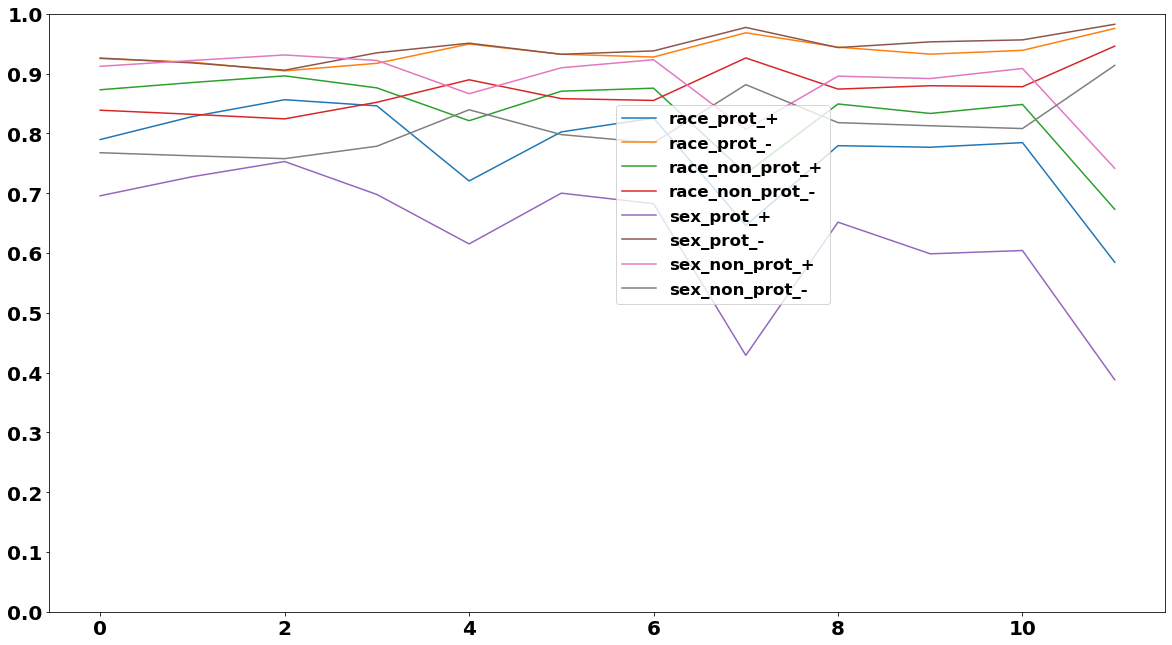

In [51]:
j=0
plt.figure(figsize=[20,11])
plt.ylim([0,1])
plt.rcParams.update({'font.size': 20})
plt.yticks(np.arange(0, 1.01, step=0.1))
for v in x_control:
    plt.plot(np.array(results_epoch)[:,j,0],label=v+'_prot_+')
    plt.plot(np.array(results_epoch)[:,j,2],label=v+'_prot_-')
    plt.plot(np.array(results_epoch)[:,j,1],label=v+'_non_prot_+')
    plt.plot(np.array(results_epoch)[:,j,3],label=v+'_non_prot_-')
    j+=1
plt.legend(loc=3, bbox_to_anchor=(0.5, 0.5),fancybox=True,fontsize='small')

In [48]:
len(np.array(results_epoch)[:,0,0])

12

In [ ]:
plt.plot(np.array(epoch_loss_class)[:,0],label='neg _class_loss')
plt.plot(np.array(epoch_loss_class)[:,1],label='pos_class_loss_df')
plt.legend(loc=3, bbox_to_anchor=(0.5, 0.5),fancybox=True,fontsize='xx-small')

#  
## In this block we run our second experiment. 
### Here to tune our network 
### we use gradients of $\max(L_g)$ which gives the error of the worst performing group at a given time

In [73]:
path='D:/L3S/MOO_NN/saved_models/FNN/best_model2_bce.pt'

net=Net()
net.to(device)
optimizer = optim.AdamW(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
epoch_loss=[]
epoch_loss_groups=[]
epoch_loss_class=[]
val_epoch_wgacc=[]
val_epoch_wpdm=[]
results_epoch=[]
best_epoch=0
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    groups_batch_loss=[]
    class_batch_loss=[]
    batch_loss=[]
    i,batch=0,4096
    while(i<len(X_train)):
        # get the inputs; data is a list of [inputs, labels]
        xc={}
        if (i+batch)<len(X_train):
            inputs, labels = torch.tensor(X_train[i:i+batch]),torch.tensor( y_train[i:i+batch])#.float()
            i=i+batch
            for v in x_control_train:
                xc[v]=torch.tensor(x_control_train[v][i:i+batch]).to(device)
        else:
            inputs, labels = torch.tensor(X_train[i:]),torch.tensor(y_train[i:])#.float()
            i=len(X_train)
            for v in x_control_train:
                xc[v]=torch.tensor(x_control_train[v][i:]).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device).float())
        loss_fairness,loss_all_groups = mmm_loss(outputs,labels.to(device),xc)
        loss_pos,loss_neg=max_class_loss(outputs, labels.to(device))


        loss=torch.max(loss_all_groups)
        loss.backward()
        optimizer.step()

        # print statistics
        if str(loss_fairness.item())!="nan":
            groups_batch_loss.append(loss_all_groups)
            class_batch_loss.append([loss_pos,loss_neg])
            running_loss += loss_fairness.item()
        #print(running_loss)
        if i%10000==0:
            print(i,batch_loss[-1],groups_batch_loss[-1])

    epoch_loss_groups.append(np.array(sum(groups_batch_loss).detach())*batch/len(X_train))
    epoch_loss_class.append(sum(np.array(class_batch_loss))*batch/len(X_train))
    print('\n--------------At Epoch ',epoch,'loss per group is: ',epoch_loss_groups[-1])
    #epoch_loss=np.array(epoch_loss)
    with torch.no_grad():
        pred1=net(torch.tensor(X_val).to(device).float())
        _,val_loss=mmm_loss(pred1,torch.tensor(y_val).to(device),x_control_val)
    print('\n--------------','validation loss per group is: ',epoch_loss_groups[-1])    
    rs1=get_fairness(sa_index,p_Group,[in_val],[np.argmax(pred1,axis=1)],X,yo)  #[0 if v[0]<0.5 else 1 for v in pred1]

    results_epoch.append(list(rs1.values()))
    wg,p,mxd=[],0,0
    for v in rs1:
        wg.append(min(rs1[v][:4]))
        if rs1[v][4]>mxd:
            mxd=rs1[v][4]
            p=v
    val_epoch_wgacc.append(min(wg))
    val_epoch_wpdm.append(mxd)
    print('\n  Validation worst group accuracy: ',val_epoch_wgacc[-1],' worst DM: ', mxd,' Attribute: ',Ft[p])
    #performance=np.array([pf1])
    if val_epoch_wpdm[-1]<=min(val_epoch_wpdm):
        torch.save(net.state_dict(),path)
        best_epoch=epoch



--------------At Epoch  0 loss per group is:  [[0.22688621 0.22174244 0.21617441 0.22258977]
 [0.23252848 0.22141059 0.2231884  0.2224515 ]]

-------------- validation loss per group is:  [[0.22688621 0.22174244 0.21617441 0.22258977]
 [0.23252848 0.22141059 0.2231884  0.2224515 ]]

  Validation worst group accuracy:  0.11538461538461539  worst DM:  0.11065931667993598  Attribute:  race

--------------At Epoch  1 loss per group is:  [[0.1439926  0.13944525 0.1296334  0.13952175]
 [0.14418751 0.1391148  0.13663136 0.14008639]]

-------------- validation loss per group is:  [[0.1439926  0.13944525 0.1296334  0.13952175]
 [0.14418751 0.1391148  0.13663136 0.14008639]]

  Validation worst group accuracy:  0.1730981256890849  worst DM:  0.201779755169259  Attribute:  sex

--------------At Epoch  2 loss per group is:  [[0.137199   0.13316831 0.11482767 0.13162472]
 [0.13460444 0.13270557 0.12979456 0.13368887]]

-------------- validation loss per group is:  [[0.137199   0.13316831 0.1148276


-------------- validation loss per group is:  [[0.1030328  0.11378928 0.08212332 0.10550328]
 [0.09698487 0.11002659 0.0957218  0.11125756]]

  Validation worst group accuracy:  0.2160970231532525  worst DM:  0.27094340231026626  Attribute:  sex

--------------At Epoch  22 loss per group is:  [[0.1031763  0.11625976 0.07676318 0.10767573]
 [0.09893471 0.1119141  0.09844964 0.11325828]]

-------------- validation loss per group is:  [[0.1031763  0.11625976 0.07676318 0.10767573]
 [0.09893471 0.1119141  0.09844964 0.11325828]]

  Validation worst group accuracy:  0.19735391400220506  worst DM:  0.2541720999812406  Attribute:  sex

--------------At Epoch  23 loss per group is:  [[0.09859711 0.11199261 0.07253147 0.10369329]
 [0.09223186 0.10766761 0.0927413  0.10890377]]

-------------- validation loss per group is:  [[0.09859711 0.11199261 0.07253147 0.10369329]
 [0.09223186 0.10766761 0.0927413  0.10890377]]

  Validation worst group accuracy:  0.2679162072767365  worst DM:  0.34181085


  Validation worst group accuracy:  0.29988974641675853  worst DM:  0.3206718620894619  Attribute:  sex

--------------At Epoch  43 loss per group is:  [[0.09540622 0.10706276 0.06435034 0.09668815]
 [0.08526855 0.10235144 0.08599733 0.10349303]]

-------------- validation loss per group is:  [[0.09540622 0.10706276 0.06435034 0.09668815]
 [0.08526855 0.10235144 0.08599733 0.10349303]]

  Validation worst group accuracy:  0.21499448732083792  worst DM:  0.2600256700756398  Attribute:  sex

--------------At Epoch  44 loss per group is:  [[0.08562372 0.10110981 0.05642552 0.09065059]
 [0.07885858 0.09568515 0.07499373 0.09731834]]

-------------- validation loss per group is:  [[0.08562372 0.10110981 0.05642552 0.09065059]
 [0.07885858 0.09568515 0.07499373 0.09731834]]

  Validation worst group accuracy:  0.20948180815876516  worst DM:  0.27026676729897225  Attribute:  sex

--------------At Epoch  45 loss per group is:  [[0.08361105 0.09719392 0.05412612 0.08721149]
 [0.07464304 0.0916

In [74]:
net=Net()
net.load_state_dict(torch.load(path))
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
#np.argmax(pred,axis=1)
with torch.no_grad():
    pred=net(torch.tensor(X_test).float())
target_name=['negative','positive']
print(confusion_matrix(y_test,np.argmax(pred,axis=1)))
print(classification_report(y_test,np.argmax(pred,axis=1),target_names=target_name))
rs1=get_fairness(sa_index,p_Group,[in_ts],[np.argmax(pred,axis=1)],X,y)
pf1=get_score([np.argmax(pred,axis=1)],[in_ts],X,y)

[[69852   328]
 [ 3600  1042]]
              precision    recall  f1-score   support

    negative       0.95      1.00      0.97     70180
    positive       0.76      0.22      0.35      4642

    accuracy                           0.95     74822
   macro avg       0.86      0.61      0.66     74822
weighted avg       0.94      0.95      0.93     74822



## Here we notice that accuracy for the +class has dropped significantly but for -class is 100% accurate
## ---------------------------------------------------------------------------------------------------------------------------

### From the plots below we see that fairness performance across all attributes are low and similar with CDM $\approx$ DM for both race and sex. This shows even though discrimination is low but it is mainly coming from a single class

['CDM', 'DM', 'CDM', 'DM', 'MMM', 'TPR', 'TNR', 'Acc', 'AUC', 'G.Mean']
[[0.0784856862739004, 0.07848568627390037, 0.12376024850424372, 0.12376024850424369, 0.11779324055666004, 0.22447221025420078, 0.9953263037902537, 0.9475020715832242, 0.6098992570222272, 0.22471600921738516]]


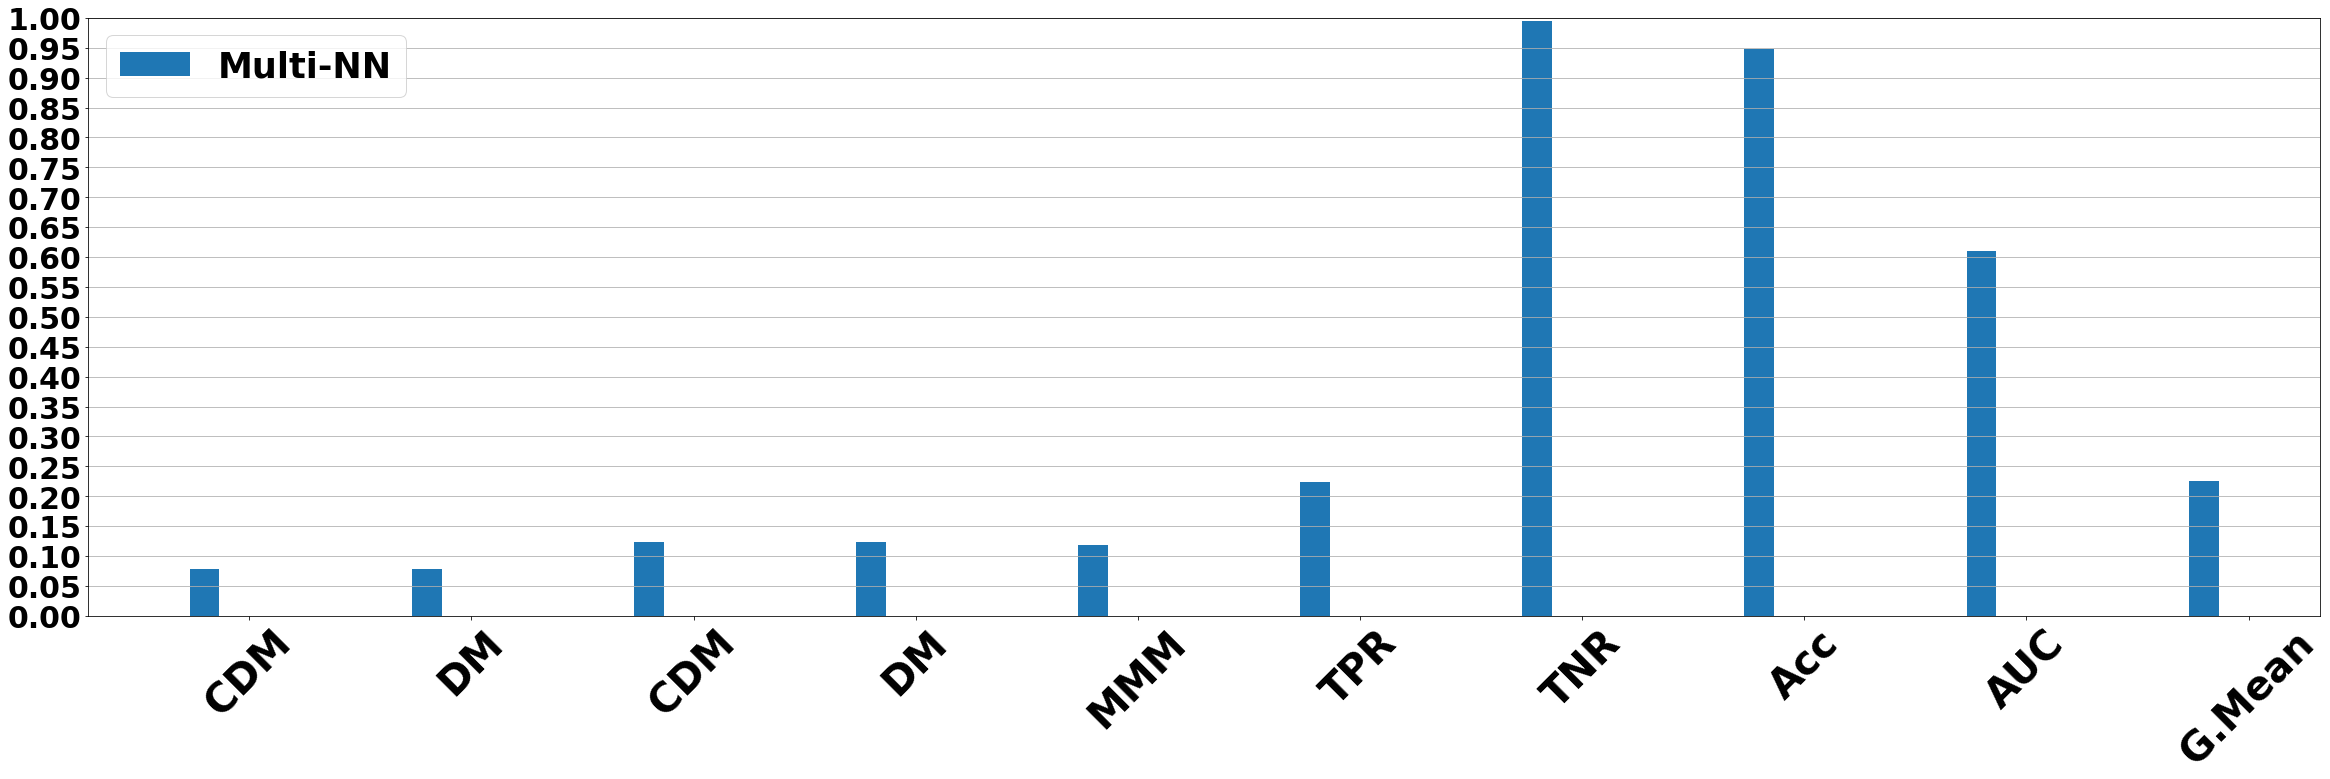

In [76]:
results=np.array([list(rs1.values())])
performance=np.array([pf1])
vis('',results,performance,L=protected,dt='kdd',clfs=['Multi-NN'])

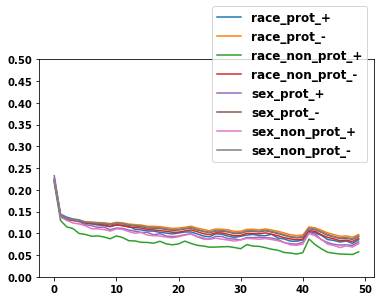

In [78]:
j=0
plt.ylim([0,0.5])
plt.rcParams.update({'font.size': 10})
plt.yticks(np.arange(0, 0.51, step=0.05))
for v in x_control:
    plt.plot(np.array(epoch_loss_groups)[:,j,0],label=v+'_prot_+')
    plt.plot(np.array(epoch_loss_groups)[:,j,1],label=v+'_prot_-')
    plt.plot(np.array(epoch_loss_groups)[:,j,2],label=v+'_non_prot_+')
    plt.plot(np.array(epoch_loss_groups)[:,j,3],label=v+'_non_prot_-')
    j+=1
plt.legend(loc=3, bbox_to_anchor=(0.5, 0.5),fancybox=True,fontsize='large')

#### Point to mention a key information which I realised now missing from the plots is that I haven't shown the current selection point. As for this loss graph we see that the difference in loss between the groups grows as we keep on training the network. 

#### Thus, if final point (epoch 50) was selected clearly we wouldn't have achieved this fair results. But as can be seen in the training code block here we used as selection criteria only validation fairness. So as best model the algorithm saves the model state right after the first epoch which remains the best model throughout. 

##   

##   

### The plot below is of validation accuracy of each groups. We see that right from the begining till the end the gap between performance in +class and -class is huge. However, the losses were coming down considerably for all groups. 
### To unearth the reason for this needs further investigation. One possible intuition is that as the training loss for the groups in the +class are always lower compared to that of -class, the network always gets tuned with gradient info from the groups in -class, causing poor learning of the +class

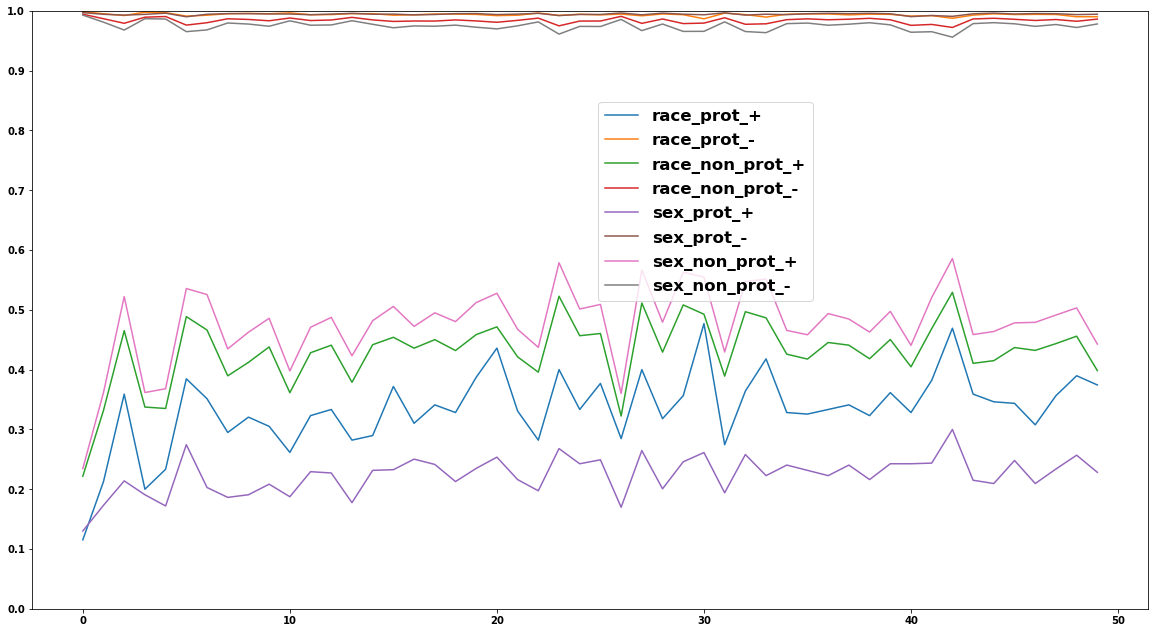

In [79]:
j=0
plt.figure(figsize=[20,11])
plt.ylim([0,1])
plt.rcParams.update({'font.size': 20})
plt.yticks(np.arange(0, 1.01, step=0.1))
for v in x_control:
    plt.plot(np.array(results_epoch)[:,j,0],label=v+'_prot_+')
    plt.plot(np.array(results_epoch)[:,j,2],label=v+'_prot_-')
    plt.plot(np.array(results_epoch)[:,j,1],label=v+'_non_prot_+')
    plt.plot(np.array(results_epoch)[:,j,3],label=v+'_non_prot_-')
    j+=1
plt.legend(loc=3, bbox_to_anchor=(0.5, 0.5),fancybox=True,fontsize='small')

#  
## In the next block we run our third and final experiment. 
### Here to tune our network using $max(max(L_{class}),max(L_g))$
### The idea is we combine the usefulness of both the above experiments to get balanced and fair performance

#### A point to note in the code block is that here we save two models, one with best worst DM and the other with best worst group performance

In [63]:
path1='D:/L3S/MOO_NN/saved_models/FNN/best_model3_best_acc.pt'
path2='D:/L3S/MOO_NN/saved_models/FNN/best_model3_best_fair.pt'

net=Net()
net.to(device)
optimizer = optim.AdamW(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
epoch_loss=[]
epoch_loss_groups=[]
epoch_loss_class=[]
val_epoch_wgacc=[]
val_epoch_wpdm=[]
results_epoch=[]
best_epoch_acc,best_epoch_fair=0,0
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    groups_batch_loss=[]
    class_batch_loss=[]
    batch_loss=[]
    i,batch=0,4096
    while(i<len(X_train)):
        # get the inputs; data is a list of [inputs, labels]
        xc={}
        if (i+batch)<len(X_train):
            inputs, labels = torch.tensor(X_train[i:i+batch]),torch.tensor( y_train[i:i+batch])#.float()
            i=i+batch
            for v in x_control_train:
                xc[v]=torch.tensor(x_control_train[v][i:i+batch]).to(device)
        else:
            inputs, labels = torch.tensor(X_train[i:]),torch.tensor(y_train[i:])#.float()
            i=len(X_train)
            for v in x_control_train:
                xc[v]=torch.tensor(x_control_train[v][i:]).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device).float())
        loss_fairness,loss_all_groups = mmm_loss(outputs,labels.to(device),xc)
        loss_pos,loss_neg=max_class_loss(outputs, labels.to(device))


        loss=torch.max(torch.max(loss_all_groups),torch.max(loss_pos,loss_neg))
        loss.backward()
        optimizer.step()

        # print statistics
        if str(loss_fairness.item())!="nan":
            groups_batch_loss.append(loss_all_groups)
            class_batch_loss.append([loss_pos,loss_neg])
            running_loss += loss_fairness.item()
        #print(running_loss)
        if i%10000==0:
            print(i,batch_loss[-1],groups_batch_loss[-1])

    epoch_loss_groups.append(np.array(sum(groups_batch_loss).detach())*batch/len(X_train))
    epoch_loss_class.append(sum(np.array(class_batch_loss))*batch/len(X_train))
    print('\n--------------At Epoch ',epoch,'loss per group is: ',epoch_loss_groups[-1])
    #epoch_loss=np.array(epoch_loss)
    with torch.no_grad():
        pred1=net(torch.tensor(X_val).to(device).float())
        _,val_loss=mmm_loss(pred1,torch.tensor(y_val).to(device),x_control_val)
    print('\n--------------','validation loss per group is: ',epoch_loss_groups[-1])    
    rs1=get_fairness(sa_index,p_Group,[in_val],[np.argmax(pred1,axis=1)],X,yo)  #[0 if v[0]<0.5 else 1 for v in pred1]

    results_epoch.append(list(rs1.values()))
    wg,p,mxd=[],0,0
    for v in rs1:
        wg.append(min(rs1[v][:4]))
        if rs1[v][4]>mxd:
            mxd=rs1[v][4]
            p=v
    val_epoch_wgacc.append(min(wg))
    val_epoch_wpdm.append(mxd)
    print('\n  Validation worst group accuracy: ',val_epoch_wgacc[-1],' worst DM: ', mxd,' Attribute: ',Ft[p])
    #performance=np.array([pf1])
    if val_epoch_wgacc[-1]>=max(val_epoch_wgacc): 
        torch.save(net.state_dict(),path1)
        best_epoch_acc=epoch
    if val_epoch_wpdm[-1]<=min(val_epoch_wpdm):
        torch.save(net.state_dict(),path2)
        best_epoch_fair=epoch


--------------At Epoch  0 loss per group is:  [[0.45102072 0.44849072 0.4476992  0.44747108]
 [0.45999318 0.44771317 0.44308332 0.44935563]]

-------------- validation loss per group is:  [[0.45102072 0.44849072 0.4476992  0.44747108]
 [0.45999318 0.44771317 0.44308332 0.44935563]]

  Validation worst group accuracy:  0.6857772877618522  worst DM:  0.36908094660005997  Attribute:  sex

--------------At Epoch  1 loss per group is:  [[0.30777505 0.30376424 0.29502062 0.30183483]
 [0.31343999 0.30249802 0.29529844 0.30481034]]

-------------- validation loss per group is:  [[0.30777505 0.30376424 0.29502062 0.30183483]
 [0.31343999 0.30249802 0.29529844 0.30481034]]

  Validation worst group accuracy:  0.7067254685777288  worst DM:  0.34708401417268486  Attribute:  sex

--------------At Epoch  2 loss per group is:  [[0.2999494  0.29513225 0.27507318 0.29335474]
 [0.30195983 0.29399247 0.28692394 0.29613116]]

-------------- validation loss per group is:  [[0.2999494  0.29513225 0.2750731


-------------- validation loss per group is:  [[0.23466155 0.25113672 0.19630414 0.24421349]
 [0.23726036 0.24799874 0.2296204  0.24974493]]

  Validation worst group accuracy:  0.7034178610804851  worst DM:  0.3509257943284676  Attribute:  sex

--------------At Epoch  22 loss per group is:  [[0.23321138 0.2467871  0.1890572  0.23923173]
 [0.22948664 0.24395747 0.22950708 0.24520035]]

-------------- validation loss per group is:  [[0.23321138 0.2467871  0.1890572  0.23923173]
 [0.22948664 0.24395747 0.22950708 0.24520035]]

  Validation worst group accuracy:  0.6990077177508269  worst DM:  0.3442673913735249  Attribute:  sex

--------------At Epoch  23 loss per group is:  [[0.22399931 0.2408781  0.18379056 0.23246382]
 [0.22345787 0.23752471 0.21480614 0.23967851]]

-------------- validation loss per group is:  [[0.22399931 0.2408781  0.18379056 0.23246382]
 [0.22345787 0.23752471 0.21480614 0.23967851]]

  Validation worst group accuracy:  0.6824696802646086  worst DM:  0.3981357637


  Validation worst group accuracy:  0.6549062844542448  worst DM:  0.3790132212198194  Attribute:  sex

--------------At Epoch  43 loss per group is:  [[0.1941922  0.21031491 0.15054593 0.20143848]
 [0.18891193 0.20630961 0.18113032 0.20814954]]

-------------- validation loss per group is:  [[0.1941922  0.21031491 0.15054593 0.20143848]
 [0.18891193 0.20630961 0.18113032 0.20814954]]

  Validation worst group accuracy:  0.6736493936052922  worst DM:  0.36852352251164633  Attribute:  sex

--------------At Epoch  44 loss per group is:  [[0.18574605 0.20349432 0.13808726 0.19346578]
 [0.18154784 0.1993749  0.17558157 0.20104168]]

-------------- validation loss per group is:  [[0.18574605 0.20349432 0.13808726 0.19346578]
 [0.18154784 0.1993749  0.17558157 0.20104168]]

  Validation worst group accuracy:  0.6945975744211687  worst DM:  0.36847844264288676  Attribute:  sex

--------------At Epoch  45 loss per group is:  [[0.1902042  0.20961778 0.14681701 0.20007954]
 [0.18779895 0.205197

In [68]:
net1=Net()
net1.load_state_dict(torch.load(path1))
net2=Net()
net2.load_state_dict(torch.load(path2))
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
#np.argmax(pred,axis=1)
with torch.no_grad():
    pred1=net1(torch.tensor(X_test).float())
    pred2=net2(torch.tensor(X_test).float())
target_name=['negative','positive']
print(confusion_matrix(y_test,np.argmax(pred1,axis=1)))
print(classification_report(y_test,np.argmax(pred1,axis=1),target_names=target_name))
rs1=get_fairness(sa_index,p_Group,[in_ts],[np.argmax(pred1,axis=1)],X,y)
pf1=get_score([np.argmax(pred1,axis=1)],[in_ts],X,y)
rs2=get_fairness(sa_index,p_Group,[in_ts],[np.argmax(pred2,axis=1)],X,y)
pf2=get_score([np.argmax(pred2,axis=1)],[in_ts],X,y)

[[59163 11017]
 [  465  4177]]
              precision    recall  f1-score   support

    negative       0.99      0.84      0.91     70180
    positive       0.27      0.90      0.42      4642

    accuracy                           0.85     74822
   macro avg       0.63      0.87      0.67     74822
weighted avg       0.95      0.85      0.88     74822



In [65]:
print(confusion_matrix(y_test,np.argmax(pred2,axis=1)))
print(classification_report(y_test,np.argmax(pred2,axis=1),target_names=target_name))

[[57430 12750]
 [  410  4232]]
              precision    recall  f1-score   support

    negative       0.99      0.82      0.90     70180
    positive       0.25      0.91      0.39      4642

    accuracy                           0.82     74822
   macro avg       0.62      0.87      0.64     74822
weighted avg       0.95      0.82      0.87     74822



In [66]:
best_epoch_acc,best_epoch_fair

(9, 8)

## In the blocks above we see performance on test set at first for the model with best worst group accuracy and second for the best fair model 
### We notice that both the models have high accuracy across all classes but has higher acurracy on minority +class.
#### ------------------------------------------------------------------------------------------------------------------------------------------

### In the plots below we see at first that the fair model tackles the issue of CDM vs DM while achieving similar performance as our first experiment model

['CDM', 'DM', 'CDM', 'DM', 'MMM', 'TPR', 'TNR', 'Acc', 'AUC', 'G.Mean']
[[0.035260555984874986, 0.1079862263802357, 0.033315166011988584, 0.32271693586701233, 0.1639967674699876, 0.8998276604911676, 0.8430179538330008, 0.8465424607735693, 0.8714228071620842, 0.8998237988080833], [0.09142722492495614, 0.09142722492495614, 0.1191455852163178, 0.29657931957556694, 0.1555279380954706, 0.9116760017233951, 0.8183243089199203, 0.8241159017401299, 0.8650001553216575, 0.9116702030690342]]


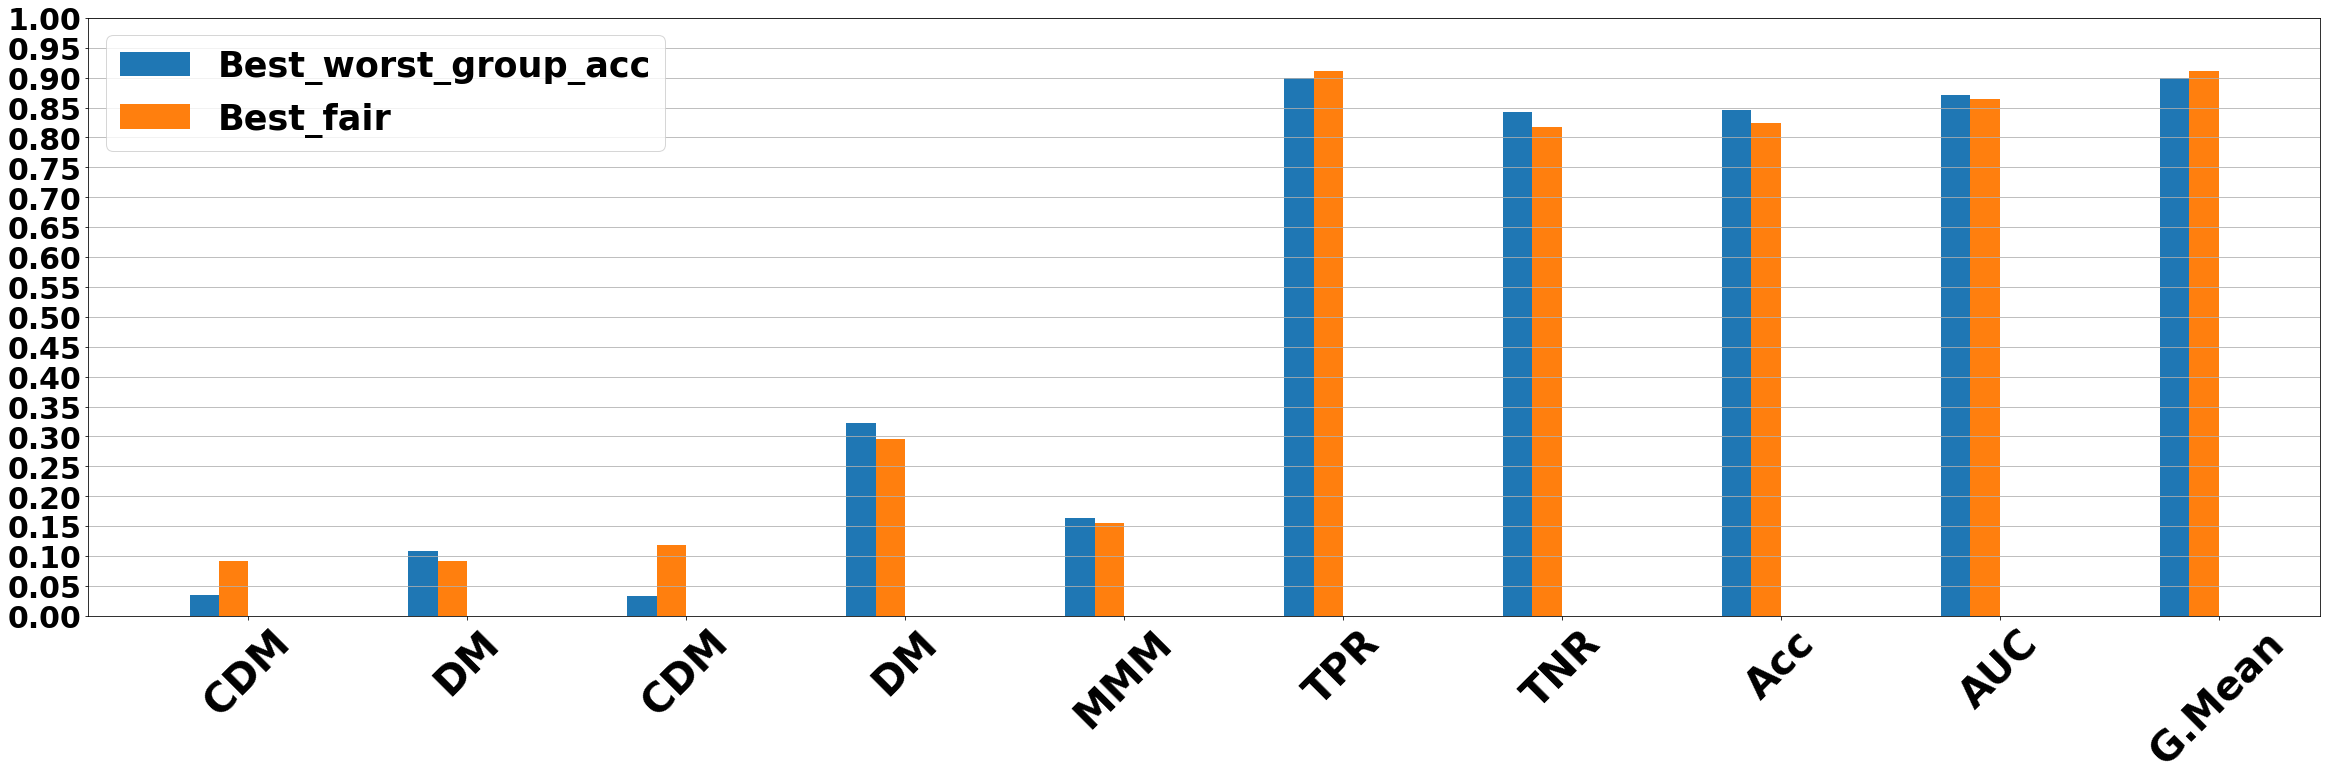

In [69]:
results=np.array([list(rs1.values()),list(rs2.values())])
performance=np.array([pf1,pf2])
vis('',results,performance,L=protected,dt='kdd',clfs=['Best_worst_group_acc','Best_fair'])

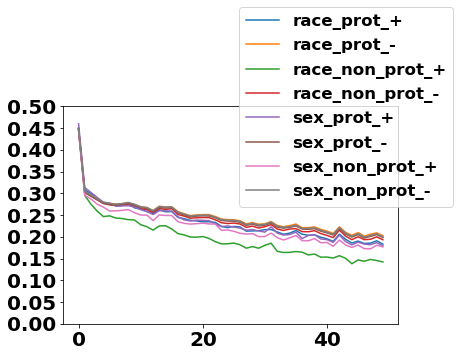

In [71]:
j=0
plt.ylim([0,0.5])
plt.rcParams.update({'font.size': 20})
plt.yticks(np.arange(0, 0.51, step=0.05))
for v in x_control:
    plt.plot(np.array(epoch_loss_groups)[:,j,0],label=v+'_prot_+')
    plt.plot(np.array(epoch_loss_groups)[:,j,1],label=v+'_prot_-')
    plt.plot(np.array(epoch_loss_groups)[:,j,2],label=v+'_non_prot_+')
    plt.plot(np.array(epoch_loss_groups)[:,j,3],label=v+'_non_prot_-')
    j+=1
plt.legend(loc=3, bbox_to_anchor=(0.5, 0.5),fancybox=True,fontsize='small')

## From the training loss plots above and validation group-accuracy plots below we see that selection at none of the available points could have ensured highly fair model like we had in the previous experiments. 

### However like in all the experiments so far we again see that sex_prot_+ have been consistantly discriminated. Solving with attention for this group may solve the problem in hand.

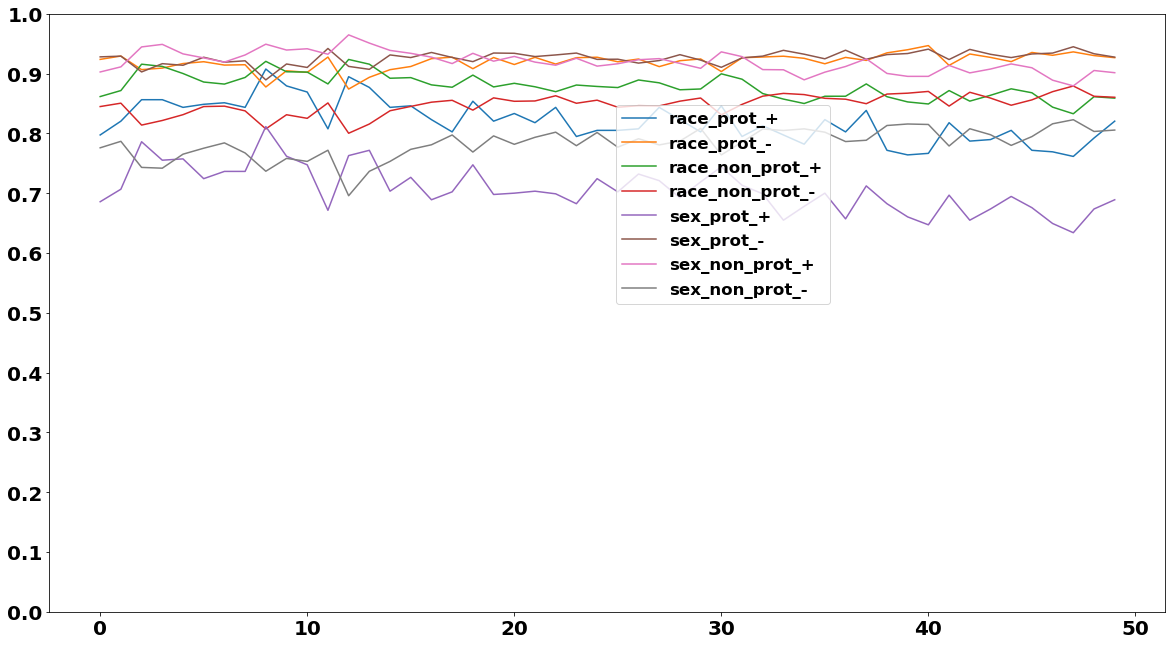

In [72]:
j=0
plt.figure(figsize=[20,11])
plt.ylim([0,1])
plt.rcParams.update({'font.size': 20})
plt.yticks(np.arange(0, 1.01, step=0.1))
for v in x_control:
    plt.plot(np.array(results_epoch)[:,j,0],label=v+'_prot_+')
    plt.plot(np.array(results_epoch)[:,j,2],label=v+'_prot_-')
    plt.plot(np.array(results_epoch)[:,j,1],label=v+'_non_prot_+')
    plt.plot(np.array(results_epoch)[:,j,3],label=v+'_non_prot_-')
    j+=1
plt.legend(loc=3, bbox_to_anchor=(0.5, 0.5),fancybox=True,fontsize='small')

## Ignore the experiments below. Here I used MSE loss instead of CE just to see if it can make any difference. 

In [80]:

class Netmse(nn.Module):

    def __init__(self):
        super(Netmse, self).__init__()
        
        self.fc1 = nn.Linear(X.shape[-1], 1024)  
        self.bn1= nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128,32)
        self.fc5 = nn.Linear(32,1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.fc4(x))
        x = F.sigmoid(self.fc5(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    

In [82]:
path='D:/L3S/MOO_NN/saved_models/FNN/model2_mse.pt'

netm=Netmse()
netm.load_state_dict(torch.load(path))

<All keys matched successfully>

In [90]:
with torch.no_grad():
    pred=netm(torch.tensor(X_test).to('cpu').float())
pred=pred.to('cpu')


In [91]:
pred=[0 if v[0]<0.5 else 1 for v in pred]

In [92]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
#np.argmax(pred,axis=1)
target_name=['negative','positive']
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred,target_names=target_name))

[[65467  4713]
 [ 1334  3308]]
              precision    recall  f1-score   support

    negative       0.98      0.93      0.96     70180
    positive       0.41      0.71      0.52      4642

    accuracy                           0.92     74822
   macro avg       0.70      0.82      0.74     74822
weighted avg       0.94      0.92      0.93     74822



['CDM', 'DM', 'CDM', 'DM', 'MMM', 'TPR', 'TNR', 'Acc', 'AUC', 'G.Mean']
[[0.18683064204707367, 0.18683064204707367, 0.35452752824873035, 0.35452752824873035, 0.2777974616547142, 0.7126238690219733, 0.9328441151325164, 0.9191815241506509, 0.8227339920772448, 0.8153324368134222]]


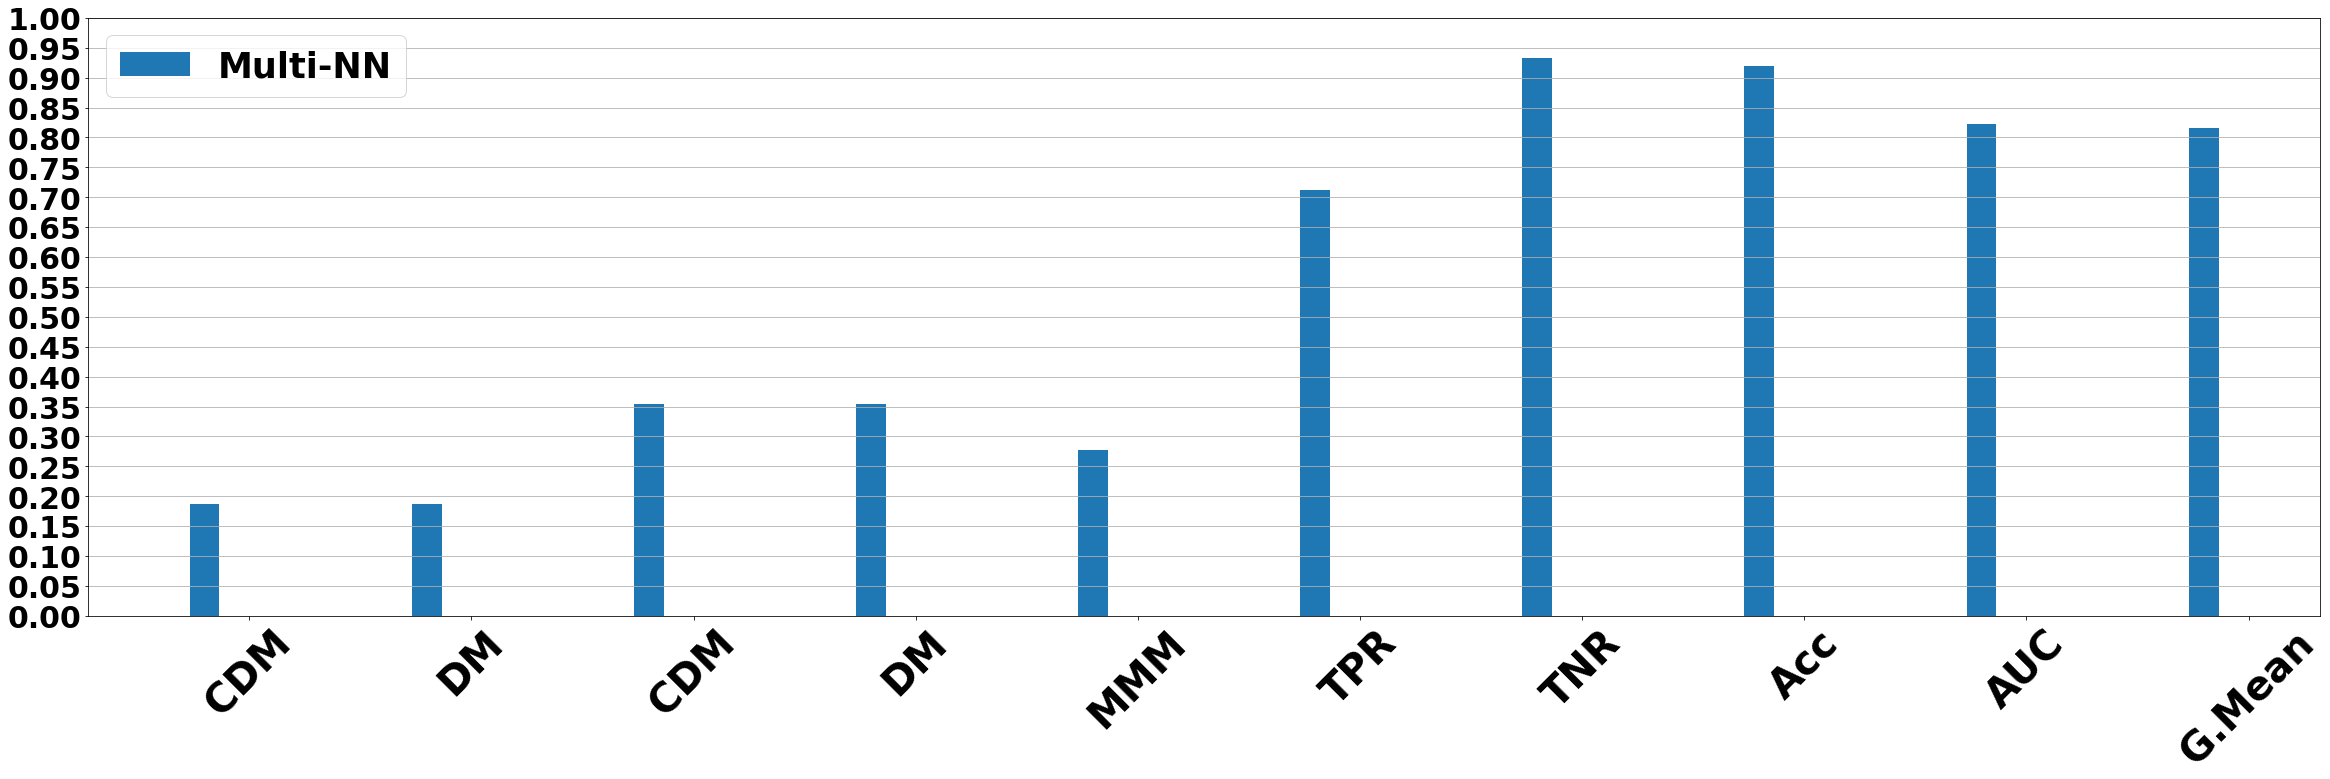

In [94]:
rs1=get_fairness(sa_index,p_Group,[in_ts],[pred],X,y)
pf1=get_score([pred],[in_ts],X,y)
results=np.array([list(rs1.values())])
performance=np.array([pf1])
vis('',results,performance,L=protected,dt='kdd',clfs=['Multi-NN'])